In [1]:
import json
import os
import re
import string
import warnings
import pickle
from tqdm import tqdm

from boilerpy3 import extractors ## FOR PARSING HTML TEXT

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import feature_extraction, metrics
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

from wordcloud import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

porter_stemmer  = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = stopwords.words('english')

from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data = data.loc[:, ['v1', 'v2']]
data.columns = ['label', 'text']
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Finding and removing duplicates

In [6]:
data[data['text']=="Sorry, I'll call later"]

,label,text
80,ham,"Sorry, I'll call later"
222,ham,"Sorry, I'll call later"
338,ham,"Sorry, I'll call later"
443,ham,"Sorry, I'll call later"
701,ham,"Sorry, I'll call later"
767,ham,"Sorry, I'll call later"
1131,ham,"Sorry, I'll call later"
1151,ham,"Sorry, I'll call later"
1484,ham,"Sorry, I'll call later"
1584,ham,"Sorry, I'll call later"


In [7]:
# data.groupby('label', axis=1)
duplicate = data[data.duplicated()]
duplicate

,label,text
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [8]:
data.drop_duplicates(inplace=True, keep='first')

In [9]:
duplicate = data[data.duplicated()]
duplicate

,label,text


In [10]:
data.shape

(5169, 2)

In [11]:
data_ham = data[data['label']=='ham']['text'].reset_index(drop=True)
data_spam = data[data['label']=='spam']['text'].reset_index(drop=True)

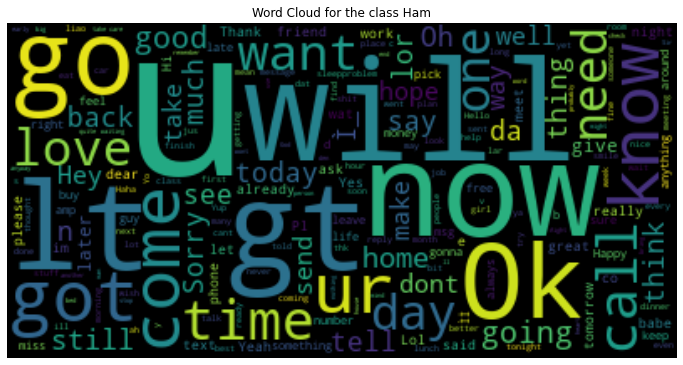

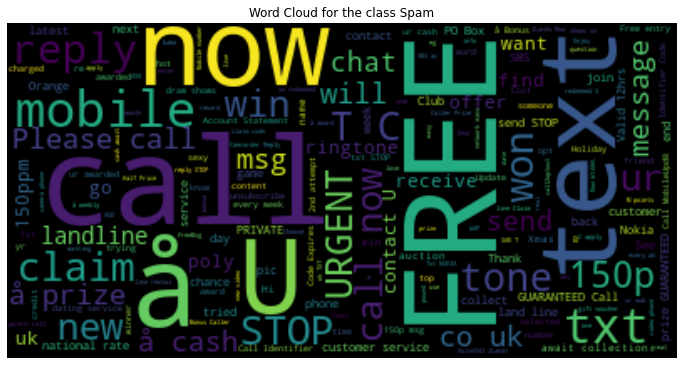

In [12]:
wordcloud_ham = wordcloud.WordCloud().generate(' '.join(data_ham.values))
plt.figure( figsize=(12,9) )
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Word Cloud for the class Ham")
plt.axis("off")
plt.show()

wordcloud_spam = wordcloud.WordCloud().generate(' '.join(data_spam.values))
plt.figure( figsize=(12,9) )
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Word Cloud for the class Spam")
plt.axis("off")
plt.show()

### CLEANING TEXT

In [13]:
from html.parser import HTMLParser
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

class TxtPProcessor:
    def __init__(self):
        pass
    
    def func2attr(self, txt, func):
        retVal = None
        
        if isinstance(txt, str):
            retVal = func(txt)
        elif isinstance(txt, list) or isinstance(txt, tuple) :
            retVal = [func(s) for s in txt]
            
        return retVal

    def basic_procs(self, txt):
        txt = self.lowercase(txt)
        # txt = self.remove_html_tags(txt)
        txt = self.replace_html_entities(txt)
        # txt = self.html_to_text(txt) ## to be used explicitly when scraping webpages
        txt = self.remove_punctuation(txt)
        txt = self.remove_whitespace(txt)
        txt = self.remove_stopwrods(txt) # This function returns array of words
        return(txt)

    def lowercase(self, txt):
        lc = txt.lower()
        return lc

    def remove_punctuation(self, txt):
        """
        This function simplifies doubled or more complex punctuation. The exception is '...'.
        """
        if txt is None:
            return ''
        
       
        return txt.translate(str.maketrans('', '', string.punctuation))
    
    def replace_html_entities(self, text):
        """Escape &, <, > as well as single and double quotes for HTML."""
        # return text.replace('&', '&amp;').  \
        #             replace('<', '&lt;').   \
        #             replace('>', '&gt;').   \
        #             replace('"', '&quot;'). \
        #             replace("'", '&#39;') 
        return text.replace('&amp;', '&').  \
                    replace('&lt;', '<').   \
                    replace('&gt;', '>').   \
                    replace('&quot;', '"'). \
                    replace('&#39;', "'") 
    
    def html_to_text(self, txt):
        ## ***  This function extracts the text content from HTML page. The page or 
        # variable should contain the html tags i.e the complete html page opening and closing tags 
        html_extractor = extractors.ArticleExtractor()
        ext_txt = html_extractor.get_content(txt)
        
        # Condenses all repeating newline characters into one single newline character
        con_txt = ' '.join([p for p in re.split('\n|\r', ext_txt) if len(p) > 0])
        return con_txt

    def remove_whitespace(self, input_string):
        """
        This function normalizes whitespaces, removing duplicates.
        """
        if input_string is None:
            return ''
        
        corrected = str(input_string)
        corrected = re.sub(r"//t", r"\t", corrected)
        corrected = re.sub(r"( )\1+", r"\1", corrected)
        corrected = re.sub(r"(\n)\1+", r"\1", corrected)
        corrected = re.sub(r"(\r)\1+", r"\1", corrected)
        corrected = re.sub(r"(\t)\1+", r"\1", corrected)
        return corrected.strip(" ")

    def remove_round_brackets(self, txt):
        return re.sub('\(.*?\)', '', txt)

    def remove_html_tags(self, txt):
        # bs = BeautifulSoup(txt, 'html.parser')
        # return bs.get_text()
        clean = re.compile('<.*?>')
        return re.sub(clean, '', txt)

    def filter_url(self, txt):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'', txt)

    def replace_urls(text):
        url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
        text = re.sub(url_regex, "<URL>", text)
        return text
    
    def remove_stopwrods(self, sent):
        tokens = word_tokenize(sent)
        filtered_sent = " ".join([word for word in tokens if word not in stop_words])
        return filtered_sent
    
    def lemmatzr(self, text):
        pass
    
    def stemmr(self, txt):
        pass
    
#     # Remove all stopwords
#     stop_words = stopwords.words('english')
#     def remove_stopwords(tokenized_sentences):
#         for sentence in tokenized_sentences:
#             yield([token for token in sentence if token not in stop_words])

#     # Lemmatize all words
#     wordnet_lemmatizer = WordNetLemmatizer()
#     def lemmatize_words(tokenized_sentences):
#         for sentence in tokenized_sentences:
#             yield([wordnet_lemmatizer.lemmatize(token) for token in sentence])

#     snowball_stemmer = SnowballStemmer('english')
#     def stem_words(tokenized_sentences):
#         for sentence in tokenized_sentences:
#             yield([snowball_stemmer.stem(token) for token in sentence])

html_text1 = """
<!doctype html>
<html>
<head>
    <title>Example Domain</title>

    <meta charset="utf-8" />
    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <body>
    %lt; &quot;&amp;;&amp;;&amp;;&amp;
    <p>  I am a fan of frozen yoghurt.</p></body>  <!--My first webpage-->
    </div>
</body>
</html>
"""

# tpp = TxtPProcessor()
# tpp.func2attr(html_text1, tpp.basic_procs)
# tpp.func2attr(["Hello World", "Hello Mohan", "Hello Ram", html_text], tpp.basic_procs)

In [14]:
data_y = data['label'].map(lambda x: 0 if x=='ham' else 1)

In [15]:
data_y.value_counts()

0    4516
1     653
Name: label, dtype: int64

In [16]:
tpp = TxtPProcessor()
data['text_cleaned'] = tpp.func2attr(list(data['text']), tpp.basic_procs)

In [17]:
data.head()

,label,text,text_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [18]:
train_x, test_x, train_y, test_y = train_test_split(data['text_cleaned'], data_y, random_state=89, stratify=data_y, test_size=0.3 )

In [19]:
cv = feature_extraction.text.CountVectorizer(stop_words = 'english')
train_x = cv.fit_transform(train_x)
test_x = cv.transform(test_x)

In [20]:
# cv.get_feature_names()

In [21]:
train_x.shape

(3618, 7274)

In [22]:
np.arange(1/1000000, 20, 0.7)

array([1.0000000e-06, 7.0000100e-01, 1.4000010e+00, 2.1000010e+00,
       2.8000010e+00, 3.5000010e+00, 4.2000010e+00, 4.9000010e+00,
       5.6000010e+00, 6.3000010e+00, 7.0000010e+00, 7.7000010e+00,
       8.4000010e+00, 9.1000010e+00, 9.8000010e+00, 1.0500001e+01,
       1.1200001e+01, 1.1900001e+01, 1.2600001e+01, 1.3300001e+01,
       1.4000001e+01, 1.4700001e+01, 1.5400001e+01, 1.6100001e+01,
       1.6800001e+01, 1.7500001e+01, 1.8200001e+01, 1.8900001e+01,
       1.9600001e+01])

In [23]:
classifier = MultinomialNB()
parameters ={'alpha': np.arange(1/1000000, 20, 0.4)}

grid_search = GridSearchCV(
    classifier, 
    parameters, 
    cv=5,
    # scoring='accuracy', n_jobs=-1, return_train_score=True)
    # scoring='f1', n_jobs=-1, return_train_score=True)
    scoring='accuracy', n_jobs=-1, return_train_score=True)

grid_result= grid_search.fit(train_x, train_y)
print('Best Params: ', grid_result.best_params_)
print('Best Score: ', grid_result.best_score_)

Best Params:  {'alpha': 4.800001000000001}
Best Score:  0.9742971657382148


In [24]:
grid_result.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__class_prior': None,
 'estimator__fit_prior': True,
 'estimator': MultinomialNB(),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'alpha': array([1.0000000e-06, 4.0000100e-01, 8.0000100e-01, 1.2000010e+00,
         1.6000010e+00, 2.0000010e+00, 2.4000010e+00, 2.8000010e+00,
         3.2000010e+00, 3.6000010e+00, 4.0000010e+00, 4.4000010e+00,
         4.8000010e+00, 5.2000010e+00, 5.6000010e+00, 6.0000010e+00,
         6.4000010e+00, 6.8000010e+00, 7.2000010e+00, 7.6000010e+00,
         8.0000010e+00, 8.4000010e+00, 8.8000010e+00, 9.2000010e+00,
         9.6000010e+00, 1.0000001e+01, 1.0400001e+01, 1.0800001e+01,
         1.1200001e+01, 1.1600001e+01, 1.2000001e+01, 1.2400001e+01,
         1.2800001e+01, 1.3200001e+01, 1.3600001e+01, 1.4000001e+01,
         1.4400001e+01, 1.4800001e+01, 1.5200001e+01, 1.5600001e+01,
         1.6000001e+01, 1.6400001e+01, 1.6800001e+01, 1.7200001e+01,
         1.7600001e+01, 1.800

In [25]:
from sklearn.metrics import roc_auc_score, classification_report
test_preds = grid_result.predict(test_x)

cls_rep = classification_report(test_y, test_preds)
print(cls_rep)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1355
           1       0.99      0.81      0.89       196

    accuracy                           0.98      1551
   macro avg       0.98      0.91      0.94      1551
weighted avg       0.98      0.98      0.97      1551



### Trying wordcloud after removing stopwords and some text preprocessing

In [26]:
tpp = TxtPProcessor()

In [27]:
data_ham_pp = tpp.func2attr(list(data_ham.values), tpp.basic_procs)
data_spam_pp = tpp.func2attr(list(data_spam.values), tpp.basic_procs)

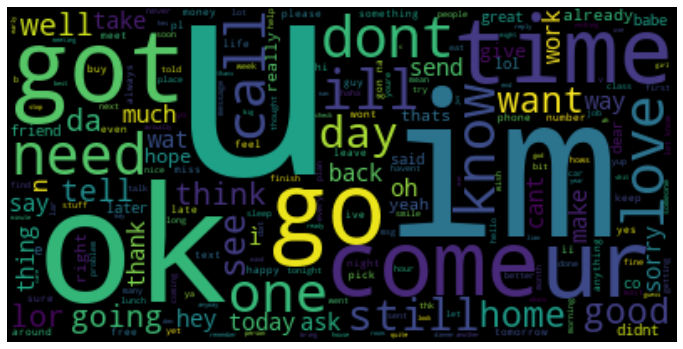

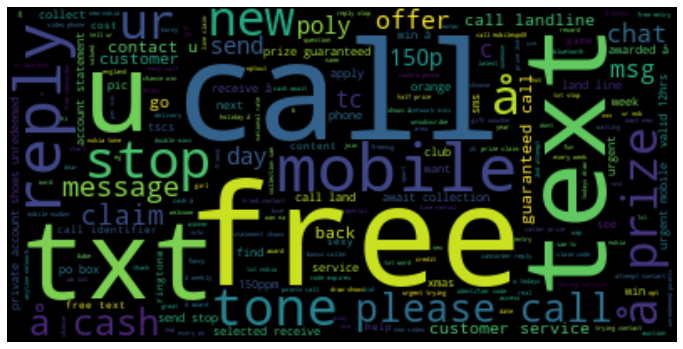

In [28]:
wordcloud_ham = wordcloud.WordCloud().generate(' '.join(data_ham_pp))
plt.figure( figsize=(12,9) )
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud_spam = wordcloud.WordCloud().generate(' '.join(data_spam_pp))
plt.figure( figsize=(12,9) )
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

<AxesSubplot:>

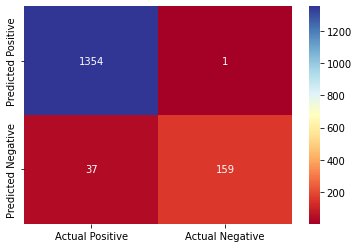

In [29]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_y, test_preds)
conf_mat = pd.DataFrame(conf_mat, columns=["Actual Positive", "Actual Negative"], index=["Predicted Positive", "Predicted Negative"] )

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='RdYlBu')